In [191]:
import pandas as pd
import sklearn

In [192]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm

In [193]:
df = pd.read_csv('dataset_moyennes_matchs.csv')

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 88 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1425 non-null   int64  
 1   match_id                       1425 non-null   int64  
 2   season                         1425 non-null   object 
 3   date                           1425 non-null   object 
 4   away_team_id                   1425 non-null   int64  
 5   away_team_name                 1425 non-null   object 
 6   home_team_id                   1425 non-null   int64  
 7   home_team_name                 1425 non-null   object 
 8   home_team_rating               1425 non-null   float64
 9   home_won_contest               1425 non-null   float64
 10  home_possession_percentage     1425 non-null   float64
 11  home_total_throws              1425 non-null   float64
 12  home_blocked_scoring_att       1425 non-null   f

### 1. Suppression des variables inutiles

In [194]:
# suppression des cotes et nb de goals dont on ne s'occupe pas pour le moment
df = df.drop(['FTHG','FTAG','B365H','B365D','B365A','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','VCH','VCD','VCA','PSCH','PSCD','PSCA'], axis=1)
# suppression de l'ancien idx
df = df.drop(['Unnamed: 0'], axis=1)
# suppression des variables informatives non nécessaires pour la modélisation
df = df.drop(['match_id','season','date','away_team_id','away_team_name','home_team_id','home_team_name'],axis=1)

### 2. Suppression des variables non significatives

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_total_tackle              1425 non-null   float64
 7   home_aerial_won                1425 non-null   float64
 8   home_aerial_lost               1425 non-null   float64
 9   home_accurate_pass             1425 non-null   float64
 10  home_total_pass                1425 non-null   float64
 11  home_won_corners               1425 non-null   float64
 12  home_shot_off_target           1425 non-null   f

- Etape préliminaire, remplacer les classes qui sont des lettres par des classes numériques (nécessaire pour la suite par exemple pour SVM)

In [195]:
df['FTR'] = df['FTR'].replace(['H','A','D'],[1,2,3])

- Création ensemble entraînement et test

In [196]:
target = df['FTR']
data = df.drop(['FTR'],axis=1)
# pour l'instant, séparation sur tout le jeu sans distinguer les périodes, voir si le module https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html serait pertinent ici
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Observation de la variance

-- pandas profiling

In [18]:
# test de l'outil pandas profiling
# ! pip install pandas-profiling
# (temps de traitement est long, à la fois pour la création de la variable report et pour la génération du fichier html, mais bcp plus rapide en json)
from pandas_profiling import ProfileReport
report = ProfileReport(df)
# le fichier html peut ensuite être ouvert pour afficher le rapport
# report.to_file("rapport_variables.html")


In [10]:
# report.to_file("your_report.json")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


In [29]:
# vérification dans le rapport des variables taggées avec "UNIQUE", "HIGH CARDINALITY", ou "UNIFORM", indicatrices d'une variance trop élevée
# Le rapport identifie away_pass comme "unique"
# "[UNIQUE] alert on column away_pass"
# étant donné que la variable home_pass n'est pas signalée, je ne supprime pas.
# vérification dans le rapport des variables taggées avec "CONSTANT", "REJECTED", "MISSING", "ZEROS" qui indiqueraient une variance trop faible
# home_post_scoring_att, away_total_offside, away_post_scoring_att ressortent avec le tag "zeros"
# pour l'instant non supprimées

-- variance threshold

In [180]:
from sklearn.feature_selection import VarianceThreshold

In [181]:
sel = VarianceThreshold(threshold = 1e-06)
sel.fit(X_train_scaled)

VarianceThreshold(threshold=1e-06)

In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_total_tackle              1425 non-null   float64
 7   home_aerial_won                1425 non-null   float64
 8   home_aerial_lost               1425 non-null   float64
 9   home_accurate_pass             1425 non-null   float64
 10  home_total_pass                1425 non-null   float64
 11  home_won_corners               1425 non-null   float64
 12  home_shot_off_target           1425 non-null   f

In [183]:
mask = sel.get_support(indices=True)

In [184]:
# toutes les variables ont été retenues
mask

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58])

Les deux tests effectués ne semblent pas indiquer de nécessité de supprimer des features pour des raisons de variance dans ce cas.

- Correlation

Observation des corrélations linéaires pour voir quelles features semblent avoir un impact sur le résultat des matches

<AxesSubplot:>

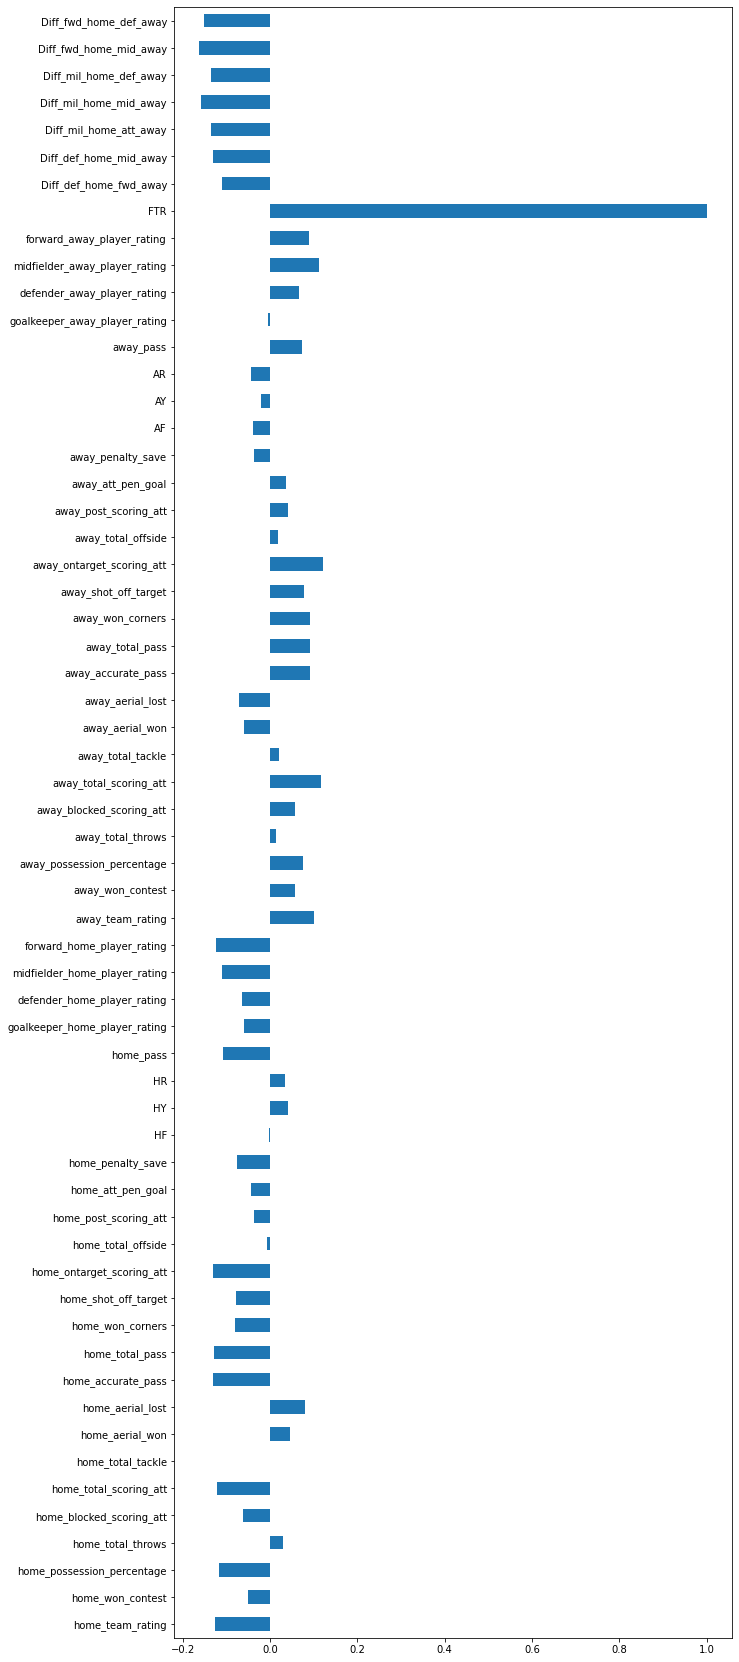

In [197]:
df.corr().loc['FTR'].plot(figsize=(10,30),kind='barh')

In [204]:
ftr_df = df.corr().loc['FTR']

In [208]:
ftr_df = abs(ftr_df)

In [209]:
ftr_df.sort_values(ascending=False)

FTR                              1.000000
Diff_fwd_home_mid_away           0.161546
Diff_mil_home_mid_away           0.158085
Diff_fwd_home_def_away           0.150469
Diff_mil_home_def_away           0.134443
Diff_mil_home_att_away           0.134443
home_ontarget_scoring_att        0.131260
Diff_def_home_mid_away           0.130515
home_accurate_pass               0.129170
home_total_pass                  0.128289
home_team_rating                 0.125204
forward_home_player_rating       0.123371
away_ontarget_scoring_att        0.122118
home_total_scoring_att           0.120199
home_possession_percentage       0.117095
away_total_scoring_att           0.116687
midfielder_away_player_rating    0.113469
midfielder_home_player_rating    0.109992
Diff_def_home_fwd_away           0.109254
home_pass                        0.106350
away_team_rating                 0.101275
away_won_corners                 0.092361
away_accurate_pass               0.092177
away_total_pass                  0

In [216]:
# corrélation Pearson

from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype

cols = []
corr_values = []
significance = []

for c in df.columns:
    if is_numeric_dtype(df[c]):
        correlation, pvalue = pearsonr(df[c], df['FTR'])
        cols.append(c)
        corr_values.append(abs(correlation))
        significance.append(pvalue <= 0.05)
        #print(c)
        #print(pearsonr(df[c], df['FTR']))
        #print(f'{c : <40}: {correlation : .4f}, significant: {pvalue <= 0.05}')


In [217]:
d = {"cols": cols, "corr": corr_values, "significance": significance}
pearson_df = pd.DataFrame(d)

In [219]:
pearson_df.sort_values(by=['corr'], ascending=False)

,cols,corr,significance
52,FTR,1.000000,True
58,Diff_fwd_home_mid_away,0.161546,True
56,Diff_mil_home_mid_away,0.158085,True
59,Diff_fwd_home_def_away,0.150469,True
57,Diff_mil_home_def_away,0.134443,True
55,Diff_mil_home_att_away,0.134443,True
13,home_ontarget_scoring_att,0.131260,True
54,Diff_def_home_mid_away,0.130515,True
9,home_accurate_pass,0.129170,True
10,home_total_pass,0.128289,True


- Select K Best

In [187]:
from sklearn.feature_selection import SelectKBest, f_regression

In [188]:
sel_kbest = SelectKBest(score_func = f_regression, k=30)
sel_kbest.fit(X_train_scaled, y_train)

SelectKBest(k=30, score_func=<function f_regression at 0x7fa64fd61430>)

In [190]:
mask = sel_kbest.get_support(indices=True)
print(mask)

for id in mask:
    print(f'{id} - {data.columns[id]}')

[ 0  2  5  8  9 10 11 12 13 21 24 25 26 28 31 35 36 37 38 39 47 50 51 52
 53 54 55 56 57 58]
0 - home_team_rating
2 - home_possession_percentage
5 - home_total_scoring_att
8 - home_aerial_lost
9 - home_accurate_pass
10 - home_total_pass
11 - home_won_corners
12 - home_shot_off_target
13 - home_ontarget_scoring_att
21 - home_pass
24 - midfielder_home_player_rating
25 - forward_home_player_rating
26 - away_team_rating
28 - away_possession_percentage
31 - away_total_scoring_att
35 - away_accurate_pass
36 - away_total_pass
37 - away_won_corners
38 - away_shot_off_target
39 - away_ontarget_scoring_att
47 - away_pass
50 - midfielder_away_player_rating
51 - forward_away_player_rating
52 - Diff_def_home_fwd_away
53 - Diff_def_home_mid_away
54 - Diff_mil_home_att_away
55 - Diff_mil_home_mid_away
56 - Diff_mil_home_def_away
57 - Diff_fwd_home_mid_away
58 - Diff_fwd_home_def_away


- Régression logistique pour évaluation des features (afin d'apporter un angle multivarié)

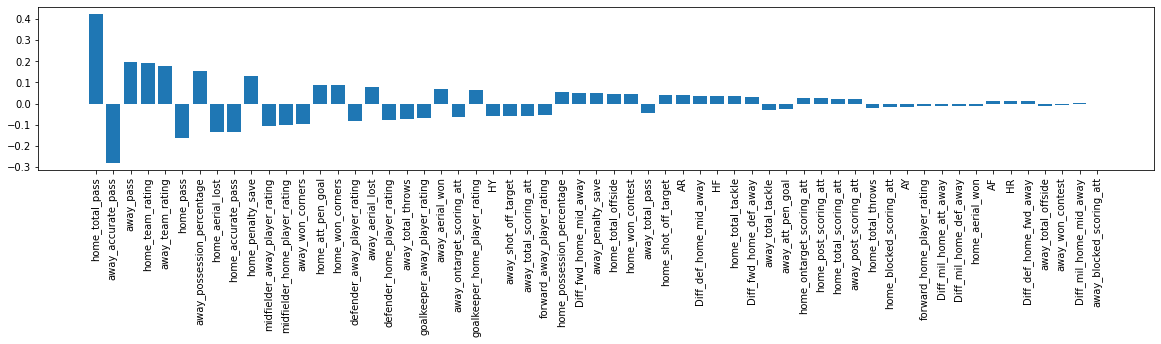

[10 35 47  0 26 21 28  8  9 17 50 24 37 16 11 49 34 23 29 48 33 39 22 19
 38 31 51  2 57 43 14  1 36 12 46 53 18  6 58 32 42 13 15  5 41  3  4 45
 25 54 56  7 44 20 52 40 27 55 30]


In [220]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')

lr.fit(X_train_scaled, y_train)

logit_coef = np.exp(lr.coef_[0]) - 1

idx = abs(logit_coef).argsort()[::-1]

plt.rcParams["figure.figsize"] = (20,3)

plt.bar(range(len(idx)), logit_coef[idx])
plt.xticks(range(len(idx)), data.columns[idx], rotation=90)

plt.show()
print(idx)


In [221]:
for id in idx[:15]:
    print(f'{id} - {data.columns[id]}')

10 - home_total_pass
35 - away_accurate_pass
47 - away_pass
0 - home_team_rating
26 - away_team_rating
21 - home_pass
28 - away_possession_percentage
8 - home_aerial_lost
9 - home_accurate_pass
17 - home_penalty_save
50 - midfielder_away_player_rating
24 - midfielder_home_player_rating
37 - away_won_corners
16 - home_att_pen_goal
11 - home_won_corners


Parmi les variables identifiées précédemment comme probablement inutiles: total throws (3/29), total tackles (6/32), total offside (14/40), att pen goal (16/42), F (18/44), Y (19/45), R (20/46), les variables 29, 14, 40, 18 apparaissent ici, ce qui nuance l'analyse précédente.

Pour l'instant les variables 6/32, 16/42, 19/45 et 20/46 sont enlevées. Il faudra sans doute affiner davantage la stratégie pour en enlever plus.

Après avoir testé en ayant enlevé ces variables, il y a un overfitting important
- Application embedded method

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_aerial_won                1425 non-null   float64
 7   home_aerial_lost               1425 non-null   float64
 8   home_accurate_pass             1425 non-null   float64
 9   home_total_pass                1425 non-null   float64
 10  home_won_corners               1425 non-null   float64
 11  home_shot_off_target           1425 non-null   float64
 12  home_ontarget_scoring_att      1425 non-null   f

In [223]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
%matplotlib inline

In [224]:
lasso = Lasso(alpha = 1)
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
alpha_grid = {'alpha':[1/i for i in range(1,10)]}
grid = GridSearchCV(estimator = lasso, param_grid = alpha_grid, cv=crossval, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'alpha': 0.1111111111111111}


5:True home_total_scoring_att
8:True home_aerial_lost
10:True home_total_pass
31:True away_total_scoring_att
33:True away_aerial_won
34:True away_aerial_lost
36:True away_total_pass


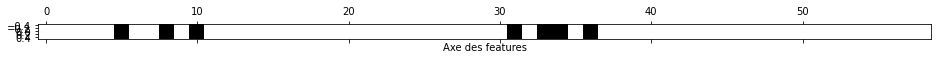

In [225]:
sel = SelectFromModel(estimator = grid.best_estimator_, threshold = 1e-10, prefit = True)
mask = sel.get_support()
for idx,val in enumerate(mask):
    if val == True:
        print(f'{idx}:{val} {data.columns[idx]}')
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

Stratégie: utiliser les variables les plus significatives de chaque test et leur pendant home/away
- Correlation
col 57 Diff_fwd_home_mid_away           0.161546 
col 55 Diff_mil_home_mid_away           0.158085
col 58 Diff_fwd_home_def_away           0.150469
col 56 Diff_mil_home_def_away           0.134443
col 54 Diff_mil_home_att_away           0.134443
- Corrélation Pearson
mêmes résultats que ci-dessus
- régression logistique
10 - home_total_pass // pendant away: 36
35 - away_accurate_pass // pendant home: 
47 - away_pass
0 - home_team_rating
26 - away_team_rating
- wrapper, prendre toutes les variables
5:True home_total_scoring_att
8:True home_aerial_lost
10:True home_total_pass
31:True away_total_scoring_att
33:True away_aerial_won
34:True away_aerial_lost
36:True away_total_pass

In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_total_tackle              1425 non-null   float64
 7   home_aerial_won                1425 non-null   float64
 8   home_aerial_lost               1425 non-null   float64
 9   home_accurate_pass             1425 non-null   float64
 10  home_total_pass                1425 non-null   float64
 11  home_won_corners               1425 non-null   float64
 12  home_shot_off_target           1425 non-null   f

In [227]:
#incl_cols = [5,7,8,27,28,29,30,6,2,24,0,22] les index parfois décalés donc il vaut mieux procéder avec les noms
data = data[['Diff_fwd_home_mid_away','Diff_mil_home_mid_away','Diff_fwd_home_def_away','Diff_mil_home_def_away',
'Diff_mil_home_att_away','home_total_pass','away_total_pass','away_accurate_pass','home_accurate_pass','away_pass','home_pass',
'home_team_rating','away_team_rating','home_total_scoring_att','away_total_scoring_att','home_aerial_lost','away_aerial_lost',
'away_aerial_won','away_aerial_lost','away_possession_percentage','home_possession_percentage']]

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Diff_fwd_home_mid_away      1425 non-null   float64
 1   Diff_mil_home_mid_away      1425 non-null   float64
 2   Diff_fwd_home_def_away      1425 non-null   float64
 3   Diff_mil_home_def_away      1425 non-null   float64
 4   Diff_mil_home_att_away      1425 non-null   float64
 5   home_total_pass             1425 non-null   float64
 6   away_total_pass             1425 non-null   float64
 7   away_accurate_pass          1425 non-null   float64
 8   home_accurate_pass          1425 non-null   float64
 9   away_pass                   1425 non-null   float64
 10  home_pass                   1425 non-null   float64
 11  home_team_rating            1425 non-null   float64
 12  away_team_rating            1425 non-null   float64
 13  home_total_scoring_att      1425 

In [14]:
# cols = [6,32,16,42,19,45,20,46]
# data = data.drop(data.columns[cols],axis=1)


In [229]:
# remise en place des jeux d'entraînement et de test avec les données modifiées
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



- PCA

In [230]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### 6. Modèles

In [231]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

Recherche de modèles de classification multi-classes performants pour le jeu de données

- SVM

In [113]:
from sklearn.svm import SVC

In [232]:
# ajout d'un OneVsRestClassifier car les numéros des classes ne correspondent pas à un ordre spécifique
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=22))

-- PCA

In [233]:
ovr_clf.fit(X_train_pca,y_train)

OneVsRestClassifier(estimator=SVC(random_state=22))

In [234]:
y_pred = ovr_clf.predict(X_test_pca)

In [235]:
print(ovr_clf.score(X_train_pca, y_train))
print(ovr_clf.score(X_test_pca, y_test))

0.5912280701754385
0.49122807017543857


In [236]:
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,98,22,1
2,50,40,0
3,55,17,2


In [237]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.49122807017543857


In [238]:
# (['H','A','D'],[1,2,3])

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.48      0.81      0.60       121
           2       0.51      0.44      0.47        90
           3       0.67      0.03      0.05        74

    accuracy                           0.49       285
   macro avg       0.55      0.43      0.38       285
weighted avg       0.54      0.49      0.42       285



-- sans PCA

In [239]:
ovr_clf.fit(X_train_scaled,y_train)
y_pred = ovr_clf.predict(X_test_scaled)
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,95,24,2
2,48,42,0
3,55,15,4


In [123]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5368421052631579


In [240]:
print(ovr_clf.score(X_train_scaled, y_train))
print(ovr_clf.score(X_test_scaled, y_test))

0.6289473684210526
0.49473684210526314


In [241]:
# (['H','A','D'],[1,2,3])

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.79      0.60       121
           2       0.52      0.47      0.49        90
           3       0.67      0.05      0.10        74

    accuracy                           0.49       285
   macro avg       0.55      0.44      0.40       285
weighted avg       0.54      0.49      0.43       285



- SGD Classifier

In [242]:
from sklearn.linear_model import SGDClassifier

In [243]:
sgd_clf = SGDClassifier()

-- avec PCA

In [244]:
sgd_clf.fit(X_train_pca,y_train)

SGDClassifier()

In [245]:
y_pred = sgd_clf.predict(X_test_pca)

In [246]:
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,82,29,10
2,49,29,12
3,50,18,6


In [247]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.4105263157894737


In [248]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [249]:
gridcv = GridSearchCV(sgd_clf, param_grid=params, scoring='accuracy', cv=3) 

In [250]:
gridcv.fit(X_train_pca, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: Conver

,params,mean_test_score,std_test_score
0,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.433333,0.030714
1,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.436842,0.055242
2,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.491228,0.012218
3,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.434211,0.052280
4,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}",0.514912,0.013980
5,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'n...",0.478947,0.024214
6,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.435965,0.027292
7,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.435965,0.019378
8,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.421053,0.015041
9,"{'alpha': 0.0001, 'loss': 'modified_huber', 'p...",0.424561,0.043045


In [251]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)



SGDClassifier(alpha=0.1, loss='modified_huber', penalty='l1')
0.5263157894736842


In [252]:
# (['H','A','D'],[1,2,3])
sgd_clf_opt1 = SGDClassifier(alpha=0.1, loss='modified_huber', penalty='l1', random_state=22)
sgd_clf_opt1.fit(X_train_pca,y_train)
y_pred = sgd_clf_opt1.predict(X_test_pca)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.87      0.61       121
           2       0.48      0.34      0.40        90
           3       0.00      0.00      0.00        74

    accuracy                           0.48       285
   macro avg       0.32      0.40      0.34       285
weighted avg       0.35      0.48      0.39       285



/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [253]:
print(sgd_clf_opt1.score(X_train_pca, y_train))
print(sgd_clf_opt1.score(X_test_pca, y_test))

0.5324561403508772
0.47719298245614034


-- sans PCA

In [254]:
sgd_clf.fit(X_train_scaled,y_train)
y_pred = sgd_clf.predict(X_test_scaled)

In [255]:
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,89,24,8
2,48,39,3
3,43,24,7


In [256]:
print(sgd_clf.score(X_train_scaled, y_train))
print(sgd_clf.score(X_test_scaled, y_test))

0.4666666666666667
0.47368421052631576


In [257]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.47368421052631576


In [141]:
gridcv = GridSearchCV(sgd_clf, param_grid=params, scoring='accuracy', cv=3) 

In [258]:
gridcv.fit(X_train_scaled, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: Conver

,params,mean_test_score,std_test_score
0,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.398246,0.101155
1,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.440351,0.058935
2,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.378947,0.070906
3,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.468421,0.054230
4,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}",0.405263,0.016222
5,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'n...",0.457895,0.061641
6,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.449123,0.062877
7,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.478070,0.024718
8,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.441228,0.053946
9,"{'alpha': 0.0001, 'loss': 'modified_huber', 'p...",0.444737,0.007443


In [259]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)

SGDClassifier(alpha=0.1, loss='modified_huber', penalty='none')
0.5298245614035088


In [260]:
# (['H','A','D'],[1,2,3])
sgd_clf_opt2 = SGDClassifier(alpha=0.01, loss='log', penalty='l1', random_state=22)
sgd_clf_opt2.fit(X_train_scaled,y_train)
y_pred = sgd_clf_opt2.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.83      0.59       121
           2       0.51      0.37      0.43        90
           3       0.00      0.00      0.00        74

    accuracy                           0.47       285
   macro avg       0.32      0.40      0.34       285
weighted avg       0.36      0.47      0.39       285



/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [261]:
print(sgd_clf_opt2.score(X_train_scaled, y_train))
print(sgd_clf_opt2.score(X_test_scaled, y_test))

0.525438596491228
0.47017543859649125


- Random Forest

In [262]:
from sklearn import ensemble

In [263]:
clf_rf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)

-- Avec PCA

In [264]:
clf_rf.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [265]:
y_pred = clf_rf.predict(X_test_pca)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3
Classe réelle,,,
1,94,19,8
2,56,29,5
3,51,16,7


In [266]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.45614035087719296


In [267]:
param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

In [268]:
gridcv = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring='accuracy', cv=3) 

In [269]:
gridcv.fit(X_train_pca, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.477193,0.016411
1,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.495614,0.010599
2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.500000,0.017055
3,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.496491,0.015544
4,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.500000,0.007747
5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.496491,0.012218
6,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.489474,0.017189
7,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.500000,0.019098
8,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.504386,0.006564
9,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.499123,0.008946


In [270]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=5,
                       n_estimators=250, n_jobs=-1, random_state=321)
0.5114035087719299


In [271]:
clf_rf_opt1 = ensemble.RandomForestClassifier(max_features='sqrt', min_samples_leaf=5,
                       n_estimators=250, n_jobs=-1, random_state=321)
clf_rf_opt1.fit(X_train_pca, y_train)
y_pred = clf_rf_opt1.predict(X_test_pca)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.47      0.81      0.60       121
           2       0.47      0.38      0.42        90
           3       0.33      0.03      0.05        74

    accuracy                           0.47       285
   macro avg       0.43      0.40      0.36       285
weighted avg       0.44      0.47      0.40       285



In [272]:
print(clf_rf_opt1.score(X_train_pca, y_train))
print(clf_rf_opt1.score(X_test_pca, y_test))

0.8482456140350877
0.47017543859649125


-- sans PCA

In [273]:
clf_rf.fit(X_train_scaled, y_train)
y_pred = clf_rf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3
Classe réelle,,,
1,88,24,9
2,47,37,6
3,43,22,9


In [159]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.543859649122807


In [274]:
gridcv = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring='accuracy', cv=3) 

In [275]:
gridcv.fit(X_train_scaled, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.473684,0.005685
1,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.503509,0.003282
2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.495614,0.003282
3,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.503509,0.013814
4,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.501754,0.020422
5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.503509,0.022052
6,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.475439,0.008684
7,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.500000,0.008595
8,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.495614,0.009689
9,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.507895,0.009846


In [276]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=5, n_jobs=-1,
                       random_state=321)
0.5175438596491228


In [277]:
clf_rf_opt2 = ensemble.RandomForestClassifier(max_features='sqrt', min_samples_leaf=5,
                      n_jobs=-1, random_state=321)

clf_rf_opt2.fit(X_train_scaled, y_train)
y_pred = clf_rf_opt2.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.80      0.62       121
           2       0.51      0.43      0.47        90
           3       0.60      0.12      0.20        74

    accuracy                           0.51       285
   macro avg       0.54      0.45      0.43       285
weighted avg       0.53      0.51      0.46       285



In [278]:
print(clf_rf_opt2.score(X_train_scaled, y_train))
print(clf_rf_opt2.score(X_test_scaled, y_test))

0.8719298245614036
0.5087719298245614


- Bagging Classifier

In [279]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(n_estimators=1000, oob_score=True)
bc.fit(X_train_scaled, y_train)
bc.oob_score_

0.5105263157894737

In [280]:
print(bc.score(X_train_scaled, y_train))
print(bc.score(X_test_scaled, y_test))

1.0
0.49122807017543857


In [281]:
y_pred = bc.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3
Classe réelle,,,
1,91,23,7
2,44,38,8
3,44,19,11


In [282]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.51      0.75      0.61       121
           2       0.47      0.42      0.45        90
           3       0.42      0.15      0.22        74

    accuracy                           0.49       285
   macro avg       0.47      0.44      0.42       285
weighted avg       0.48      0.49      0.46       285



- XG Boost

In [283]:
import xgboost as xgb

In [284]:
classes=list(target.unique())

In [293]:
target.unique()

array([2, 1, 3])

In [299]:
# Lorsque le bon nombre de classes est renseigné, xgboost ne fonctionne pas
# (Mais bizarrement cela marche quand on met à 4)
params = {'objective': 'multi:softprob','num_class':3}

In [295]:
train = xgb.DMatrix(data=X_train_scaled, label=y_train)

In [296]:
test = xgb.DMatrix(data=X_test_scaled, label=y_test)

In [297]:
# bst_cv = xgb.cv(params=params,
#                dtrain=train,
#                num_boost_round=100,
#                nfold=2,
#                early_stopping_rounds=60,
#                evals=[(train, 'train'), (test, 'eval')])
# bst_cv

xgb1 = xgb.train(params=params, dtrain=train, num_boost_round=700, evals=[(train, 'train'), (test, 'eval')])

XGBoostError: [14:30:57] /Users/runner/work/xgboost/xgboost/src/objective/multiclass_obj.cu:120: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012be16814 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x000000012bf03a76 xgboost::obj::SoftmaxMultiClassObj::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 1094
  [bt] (2) 3   libxgboost.dylib                    0x000000012bebaf44 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 612
  [bt] (3) 4   libxgboost.dylib                    0x000000012be0bb19 XGBoosterUpdateOneIter + 137
  [bt] (4) 5   _ctypes.cpython-38-darwin.so        0x000000010a285f17 ffi_call_unix64 + 79
  [bt] (5) 6   ???                                 0x00007ffee60be6a0 0x0 + 140732757960352



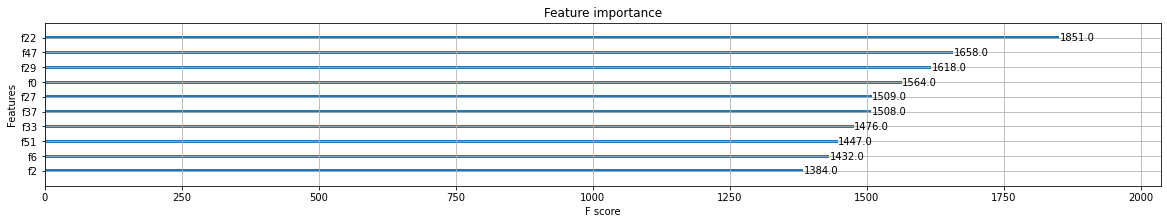

In [170]:
xgb.plot_importance(xgb1, max_num_features=10);

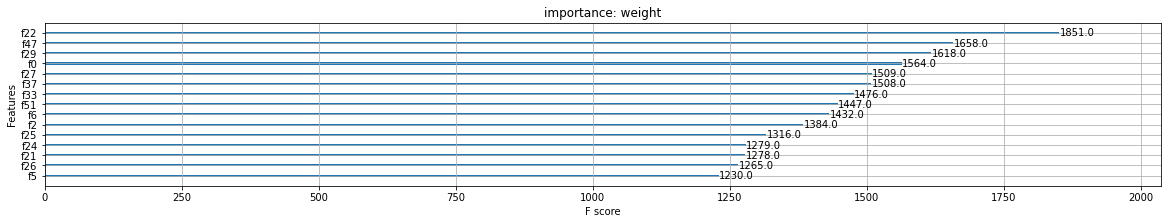

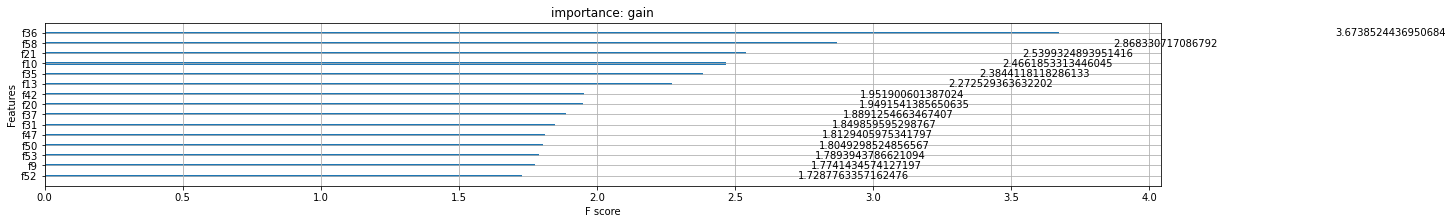

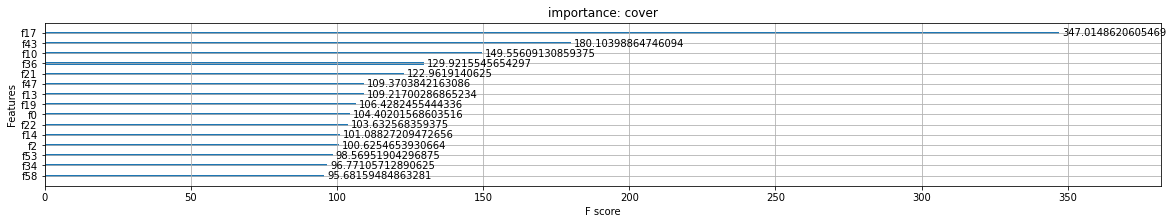

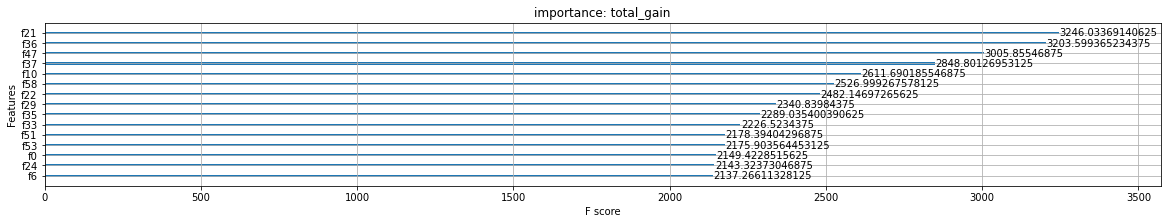

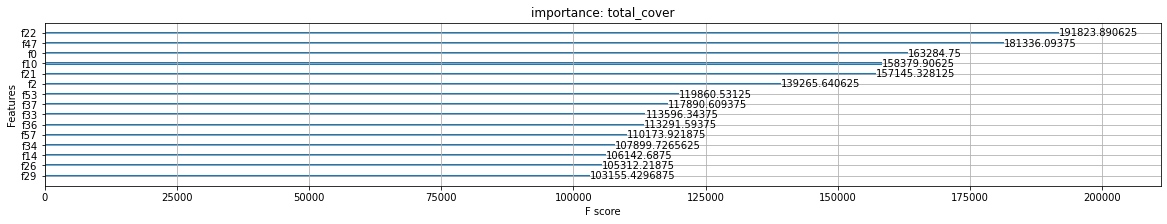

In [171]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb1 ,max_num_features=15, importance_type=f, title='importance: '+f);

In [298]:
#preds = xgb1.predict(test)

#score = accuracy_score(y_test, preds)
#print('score:{0:.4f}'.format(score))



#xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))

# pd.crosstab(pd.Series(y_test), preds, rownames=['Classe réelle'], colnames=['Classe prédite'])